# HW2 - Q2: MNIST (35 points)

**Keywords**: Multiclass Classification, Least Squares Regression, PyTorch

**About the dataset**: \
*   The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
*   The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.
*   However because of compute limitations, we will use a much smaller dataset with size $8\times 8$ images. These images are loaded from `sklearn.datasets`.

**Agenda**:
* In this programming challenge, you will be performing multiclass classification on the simplified MNIST dataset.
* You will be applying Multiclass Logistic Regression from scratch. You will work with both Mean Square Error (L2) loss and Cross Entropy (CE) loss with gradient descent (GD) as well as stochastic/mini-batch gradient descent (SGD). 
* You will also see how using PyTorch does much of the heavylifting for modeling and training.
* Finally, you will train a 2-hidden-layer Neural Network model on the image dataset.
* All the predictions will be evaluated on a test set.

**Note:**
* Hardware accelaration is not needed but is recommended!
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters. 
  * You can also move a declared torch tensor/model to device using `.to(device)`. 
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.



---



In [54]:
# !!DO NOT EDIT!!
# imports
import torch
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# loading the dataset directly from the scikit-learn library
dataset = load_digits()
X = dataset.data
y = dataset.target
print('Number of images:', X.shape[0])
print('Number of features per image:', X.shape[1])

Number of images: 1797
Number of features per image: 64


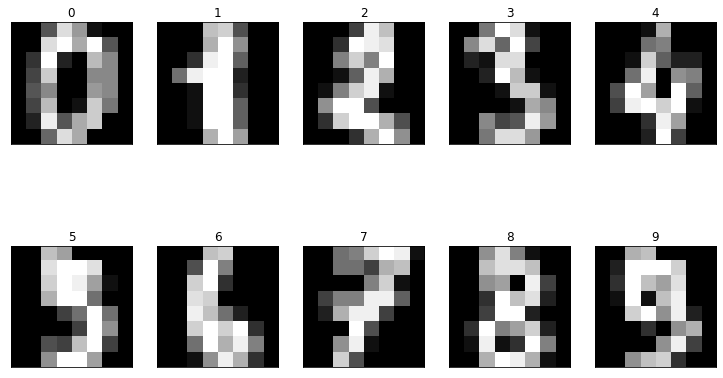

In [55]:
# !!DO NOT EDIT!!
# utility function to plot gallery of images
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# visualize some of the images of the MNIST dataset
plot_gallery(X, y, 8, 8, 2, 5)

In [56]:
# !!DO NOT EDIT!!
# Let us split the dataset into training and test sets in a stratified manner.
# Note that we are not creating evaluation datset as we will not be tuning hyper-parameters
# The split ratio is 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of train dataset:', X_train.shape)
print('Shape of evaluation dataset:', X_test.shape)

Shape of train dataset: (1437, 64)
Shape of evaluation dataset: (360, 64)


In [57]:
# !!DO NOT EDIT!!
# define some constants - useful for later
num_classes = len(np.unique(y)) # number of target classes = 10 -- (0,1,2,3,4,5,6,7,8,9)
num_features = X.shape[1]       # number of features = 64
max_epochs = 100000             # max number of epochs for training
lr = 1e-2                       # learning rate
tolerance = 1e-6                # tolerance for early stopping during training

In [58]:
# !!DO NOT EDIT!!
# Hardware Accelaration: to set device if using GPU.
# You can change runtime in colab by naviagting to (Runtime->Change runtime type), and selecting GPU in hardware accelarator.
# NOTE that you can run this homework without GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'



---



### **(a)** In this section, we will apply multiclass logistic regression from scratch with one-vs-all strategy using gradient descent (GD) as well as stochastic gradient descent (SGD) with Mean Squared Error (MSE) loss. (8 points)
### We will be using a linear model $y^{(i)} = W \mathbf{x}^{(i)},$ where 
$ W_{p\times n}= \begin{bmatrix}
\leftarrow & \mathbf{w}_1^\top & \rightarrow \\
\leftarrow & \mathbf{w}_2^\top & \rightarrow\\
 & \vdots &  \\
\leftarrow & \mathbf{w}_p^\top & \rightarrow \\
\end{bmatrix}$, and $p$ is the number of target classes. Also, $\mathbf{x}^{(i)}\in \mathbb{R}^n, y^{(i)}\in \mathbb{R}$, and
### 

$X = \begin{bmatrix}
\uparrow &  \uparrow & \dotsm &  \uparrow\\
\mathbf{x}^{(1)} & \mathbf{x}^{(2)} & \dotsm & \mathbf{x}^{(m)} \\
\downarrow & \downarrow  & \dotsm & \downarrow  \\
\end{bmatrix}, Y = \begin{bmatrix}
y^{(1)}\\
y^{(2)} \\
\vdots \\
y^{(m)} \\
\end{bmatrix}$, where $m$ is the number of datapoints.


### **#1.** Follow the steps outlined below:

In [59]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [60]:
# 1. Scale the features between 0 and 1 
# To scale, you can directly use the MinMaxScaler from sklearn.
#######
# !!!! YOUR CODE HERE !!!!

scalar = MinMaxScaler()
scalar.fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# output variable names -  X_train, X_test
#######

In [61]:
X_train.shape
# y_train
# y_train.shape

(1437, 64)

In [62]:
# 2. One-Hot encode the target labels
# To one-hot encode, you can use the OneHotEncoder from sklearn
#######
# !!!! YOUR CODE HERE !!!!

encoder = OneHotEncoder()

y_train_one =  encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_test_one =  encoder.fit_transform(y_test.reshape(-1,1)).toarray()

# output variable names -  y_train_one, y_test_one
#######
print('Shape of y_train_one:',y_train_one.shape)
print('Shape of y_test_one:',y_test_one.shape)

# y_test_one[3].toarray()

Shape of y_train_one: (1437, 10)
Shape of y_test_one: (360, 10)


**Note:** Here we need to define the model prediction. The input matrix is $X_{n\times m}$ where $m$ is the number of examples, and $n$ is the number of features. The linear predictions can be given by: $Y = WX + b$ where $W$ is a $p\times n$ weight matrix and $\mathbf{b}$ is a $p$ size bias vector. $p$ is the number of target labels.

### **#2.** Define a function `linear_model` that takes as input a weight matrix (`W`), bias vector (`b`), and input data matrix of size $m\times n$ (`XT`). This function should return the predictions $\hat{y}$. 

In [63]:
#######
# !!!! YOUR CODE HERE !!!!

def linear_model(W, b, XT):
    return  XT @ W.T + b
#######

**Note:** The loss function that we would be using is the Mean Square Error (L2) Loss:\
$\displaystyle MSE = \frac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$, where $m$ is the number of examples, $\hat{y}^{(i)}$ is the 
predicted value and $y^{(i)}$ is the ground truth.

### **#3.**Define a function `mse_loss` that takes as input prediction (`y_pred`) and actual labels (`y`), and returns the MSE loss.

In [64]:
#######
# !!!! YOUR CODE HERE !!!!

def mse_loss(y_pred, y):
    diff = y - y_pred
    return torch.sum(diff*diff) / len(diff)

#######

In the following part, we will do some setup required for training such as initializing weights and biases moving everything to torch tensors.

### **#4.** Define a function: `initializeWeightsAndBiases` that returns tuple `(W, b)`, where `W` is a randomly generated torch tensor of size `num_classes x num_features`, and `b` is a randomly generated torch vector of size `num_classes`. For both the tensors, set `requires_grad=True` in parameters.

Move all training and testing data to torch tensors with `dtype=float32`. Remember to set `device=device` in parameters.

In [65]:
#######
# !!!! YOUR CODE HERE !!!!

def initializeWeightAndBiases():
    W = torch.rand((num_classes, num_features), requires_grad=True, dtype = torch.float32, device=device )
    b = torch.rand(num_classes, requires_grad=True, dtype = torch.float32,  device = device)
    return W, b


X_train_torch = torch.tensor(X_train, dtype = torch.float32, device = device)
y_train_one_torch = torch.tensor(y_train_one, dtype = torch.float32, device = device)
X_test_torch = torch.tensor(X_test, dtype = torch.float32, device = device)
y_test_one_torch = torch.tensor(y_test_one, dtype = torch.float32, device = device)


# output variable names -  X_train_torch, X_test_torch, y_train_one_torch, y_test_one_torch
#######

### **#5.** In this part we will implement the code for training. Given below is a function: `train_linear_regression_model` that takes as input max number of epochs (`max_epochs`), batch size (`batch_size`), Weights (`W`), Biases (`b`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`). It return a tuple `(W,b,losses)` where `W,b` are the trained weigths and biases respectively, and `losses` is a list of tuples of loss logged every $100^{th}$  epoch.

Complete each of the steps outlines below. You can go through [this](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#ea0d) article for reference.

In [66]:
# Define a function train_linear_regression_model
def train_linear_regression_model(max_epochs, batch_size, W, b, X_train, y_train, lr, tolerance):
  losses = []
  prev_loss = float('inf')
  number_of_batches = math.ceil(len(X_train)/batch_size)

  # optimizer = torch.optim.SGD(params = [W,b], lr=lr)

  for epoch in tqdm(range(max_epochs)):
    for i in range(number_of_batches):
      X_train_batch = X_train[i*batch_size: (i+1)*batch_size]
      y_train_batch = y_train[i*batch_size: (i+1)*batch_size]
     
      #######
      # !!!! YOUR CODE HERE !!!!
      # 7. do prediction
      y_pred = linear_model(W,b, X_train_batch)

      # 8. get the loss
      loss = mse_loss(y_pred= y_pred, y = y_train_batch)

      # 9. backpropagate loss
      loss.backward()

      # 10. update the weights and biasees
      with torch.no_grad():
        W -= lr*W.grad
        b -= lr*b.grad

        # 11. set the gradients to zero
        W.grad.zero_()
        b.grad.zero_()
      
      #######

    # log loss every 100th epoch and print every 5000th epoch:
    if epoch%100==0:
      losses.append((epoch, loss.item()))
      if epoch%5000==0:
        print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    # break if decrease in loss is less than threshold
    if abs(prev_loss-loss)<=tolerance:
      break
    else:
      prev_loss=loss  

  # return updated weights, biases, and logged losses
  return W, b, losses

### **#6.** Initialize weights and biases using the `initializeWeightsAndBiases` function that you defined earlier, and train your model using function `train_linear_regression_model` defined above. Use full batch (set `batch_size=len(X_train)` for training (Gradient Descent). Also plot the graph of loss vs number of epochs (Recall that values for learning rate (`lr`) and tolerance (`tolerance`) are already defined above).

In [67]:
W, b = initializeWeightAndBiases()
W.shape, b.shape

(torch.Size([10, 64]), torch.Size([10]))

In [68]:
#######
# !!!! YOUR CODE HERE !!!!

W, b = initializeWeightAndBiases()
W, b, losses = train_linear_regression_model(max_epochs=max_epochs,batch_size=len(X_train),W = W, b = b, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance );

#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 1073.1507568359375
Epoch: 5000, Loss: 0.39907556772232056
Epoch: 10000, Loss: 0.3448902368545532


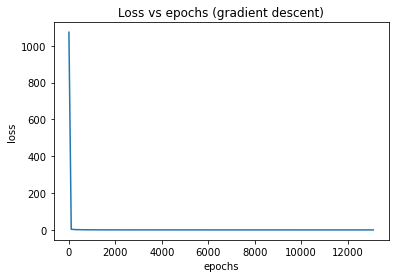

In [69]:
# Plot loss vs epochs

plt.title("Loss vs epochs (gradient descent)")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)
# losses

In [70]:
# !!DO NOT EDIT!!
# print accuracies of model
predictions_train = linear_model(W,b,X_train_torch).to('cpu')
predictions_test = linear_model(W,b,X_test_torch).to('cpu')
y_train_pred = torch.argmax(predictions_train, dim=1).numpy()

y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

Train accuracy: 0.9485038274182325
Test accuracy: 0.9388888888888889


### **#7.** Now, retrain the above model with `batch_size=64` (Stochastic/Mini-batch Gradient Descent) keeping else everything same. Like before, plot the graph between loss and number of epochs.

In [71]:
W, b = initializeWeightAndBiases()
W, b, losses = train_linear_regression_model(max_epochs=max_epochs,batch_size=64,W = W, b = b, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance );

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.480053424835205


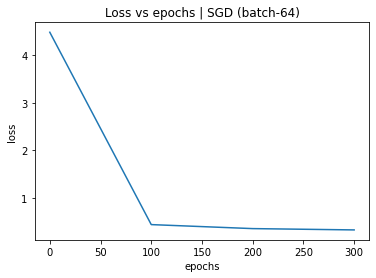

In [72]:
# Plot loss vs epochs

plt.title("Loss vs epochs | SGD (batch-64)")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)
# losses

In [73]:
# !!DO NOT EDIT!!
# print accuracies of model
predictions_train = linear_model(W,b,X_train_torch).to('cpu')
predictions_test = linear_model(W,b,X_test_torch).to('cpu')
y_train_pred = torch.argmax(predictions_train, dim=1).numpy()

y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

Train accuracy: 0.9471120389700766
Test accuracy: 0.9388888888888889




---



### **(b)** In the previous question, we defined the model, loss, and even the gradient update step. We also had to manully set the grad to zero. In this question, we will re-implement the linear model and see how we can directly use Pytorch to do all this for us in a few simple steps. (6 points)

In [74]:
# !! DO NOT EDIT !!
# common utility function to print accuracies
def print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test):
  predictions_train = model(X_train_torch).to('cpu')
  predictions_test = model(X_test_torch).to('cpu')
  y_train_pred = torch.argmax(predictions_train, dim=1).numpy()
  y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
  print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
  print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

### **#1.** Define the linear model using PyTorch

In [75]:
#######
# !!!! YOUR CODE HERE !!!!
# Define a model class using torch.nn
class Linear_Model(torch.nn.Module):
  def __init__(self):
    super(Linear_Model, self).__init__()
    # Initalize various layers of model as instructed below
    # 1. initialze one linear layer: num_features -> num_targets
    self.linear = torch.nn.Linear(num_features, num_classes, bias=True)


  def forward(self, X):
    # 2. define the feedforward algorithm of the model and return the final output
    output =  self.linear(X)
    return output

#######

### **#2.** In this part we will implement a general function for training a PyTorch model. Define a general training function: `train_torch_model` that takes as input an initialized torch model (`model`), batch size (`batch_size`), initialized loss (`criterion`), max number of epochs (`max_epochs`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`). This function will return a tuple `(model, losses)`, where `model` is the trained model, and `losses` is a list of tuples of loss logged every $100^{th}$ epoch. Complete each of the steps outlines below. You can go through [this](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#ea0d) article for reference.  You can also refer Q3-(d) from HW1.

In [76]:
# Define a function train_torch_model
def train_torch_model(model, batch_size, criterion, max_epochs, X_train, y_train, lr, tolerance):
    losses = []
    prev_loss = float('inf')
    number_of_batches = math.ceil(len(X_train)/batch_size)
  
    #######
    # !!!! YOUR CODE HERE !!!!
    # 3. move model to device
    model = model.to(device)

    # 4. define optimizer (use torch.optim.SGD (Stochastic Gradient Descent))
    # Set learning rate to lr and also set model parameters
    optimizer = torch.optim.SGD(params = model.parameters(), lr=lr)

    for epoch in tqdm(range(max_epochs)):
        for i in range(number_of_batches):
            X_train_batch = X_train[i*batch_size: (i+1)*batch_size]
            y_train_batch = y_train[i*batch_size: (i+1)*batch_size]

            # 5. reset gradients
            optimizer.zero_grad()

            # 6. prediction
            y_pred = model(X_train_batch)

            # 7. calculate loss
            loss = criterion(y_pred,y_train_batch)

            # 8. backpropagate loss
            loss.backward()

            # 9. perform a single gradient update step
            optimizer.step()

    #######

        # log loss every 100th epoch and print every 5000th epoch:
        if epoch%100==0:
            losses.append((epoch, loss.item()))
            if epoch%5000==0:
                print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))
    
        # break if decrease in loss is less than threshold
        if abs(prev_loss-loss)<=tolerance:
            break
        else:
            prev_loss=loss  

    # return updated model and logged losses
    return model, losses

### **#3.** Initialize your model and loss function. Use `nn.MSELoss`. Use full batch for training (Gradient Descent). Also plot the graph of loss vs number of epochs.

In [77]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = torch.nn.MSELoss()

model, losses = train_torch_model(model, batch_size=len(X_train), criterion = criterion, max_epochs= max_epochs, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance )
# losses
#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.16528616845607758
Epoch: 5000, Loss: 0.03951551765203476


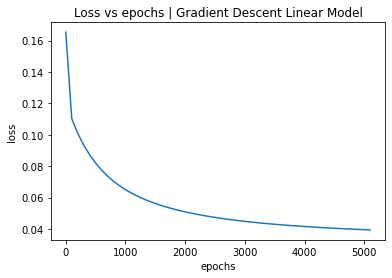

In [78]:
plt.title("Loss vs epochs | Gradient Descent Linear Model")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)

In [79]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9137091162143354
Test accuracy: 0.8916666666666667


### **#4.** Now, retrain the above model with `batch_size=64` (Stochastic/Mini-batch Gradient Descent) keeping else everything same. Like before, plot the graph between loss and number of epochs.

In [80]:
#######
# !!!! YOUR CODE HERE !!!!

model = Linear_Model()
criterion = torch.nn.MSELoss()

model, losses = train_torch_model(model, batch_size=64, criterion = criterion, max_epochs= max_epochs, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance )

#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.12727196514606476


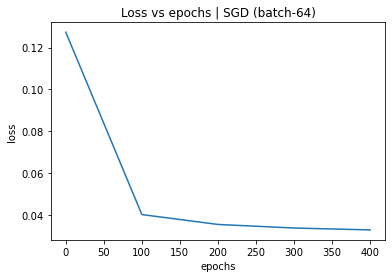

In [81]:
plt.title("Loss vs epochs | SGD (batch-64)")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)

In [82]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9345859429366736
Test accuracy: 0.9444444444444444




---



### **(c)** Now, instead of using MSELoss, we will use a much more natural loss function for logistic regression task which is the Cross Entropy Loss. (8 points)
**Note:**
The [Cross Entropy Loss](https://ebookreading.net/view/book/EB9781789130331_73.html) for multiclass calssification is the mean of the negative log likelihood of the output logits after softmax:\
$L = \underbrace{\frac{1}{m} \sum_{i=1}^m \underbrace{-y^{(i)} \underbrace{log \underbrace{\frac{e^{\hat{y}^{(i)}}}{\sum_{j=1}^p e^{\hat{y}^{(j)}}}}_{\text{Softmax}}}_{\text{LogSoftmax}}}_{\text{Negative Log Likelihood (NLL)}}}_{\text{Cross Entropy (CE) Loss }}$,


where $y^{(i)}$ is the ground truth, and $\hat{y}^{(k)}$ (also called as *logits*) represent the outputs of the last linear layer of the model. 

### **#1.** Instead of `nn.MSELoss`, train the above model with `nn.CrossEntropyLoss`. Use full-batch. Also plot the graph between loss and number of epochs.

In [83]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = torch.nn.CrossEntropyLoss()

model, losses = train_torch_model(model, batch_size=len(X_train), criterion = criterion, max_epochs= max_epochs, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance )
# losses
#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.382164478302002
Epoch: 5000, Loss: 0.4084785282611847
Epoch: 10000, Loss: 0.2739774286746979


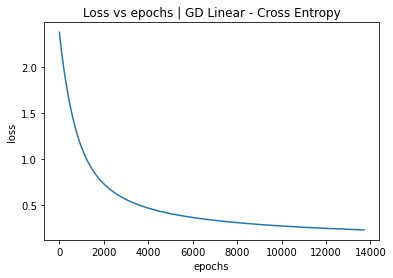

In [84]:
plt.title("Loss vs epochs | GD Linear - Cross Entropy")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)

In [85]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9596381350034795
Test accuracy: 0.95


### **#2.** Perform the same task above with `batch_size=64`. Also plot the graph of loss vs epochs.

In [86]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = torch.nn.CrossEntropyLoss()

model, losses = train_torch_model(model, batch_size=64, criterion = criterion, max_epochs= max_epochs, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance )
# losses
#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.16865611076355


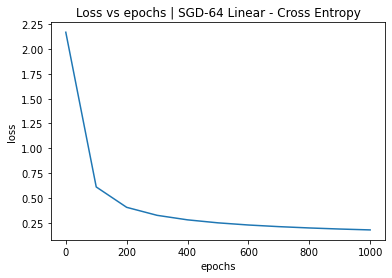

In [87]:
plt.title("Loss vs epochs | SGD-64 Linear - Cross Entropy")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)

In [88]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9679888656924147
Test accuracy: 0.9527777777777777




---



### **(d)** Now, we will train a neural network in pytorch with two hidden layers of sizes 32 and 16 neurons. We will use non-linear ReLU activations thus effectively making this a non-linear model. We will use this neural network model for multi-class classification with Cross Entropy Loss. (6 points)

**Note:** The neural network model output can be represented mathematically as below:\
$\hat{y}^{(i)}_{10\times1} = W^{(3)}_{10\times 16}\sigma(W^{(2)}_{16\times 32}\sigma(W^{(1)}_{32\times 64}\mathbf{x}^{(i)}_{64\times1}+\mathbf{b}^{(1)}_{32\times1})+\mathbf{b}^{(2)}_{16\times1})+\mathbf{b}^{(3)}_{10\times1}$, \
where $\sigma$ represents ReLU activation, $W^{(i)}$ is the weight of the $i^{th}$ linear layer, and $\mathbf{b}^{(i)}$ is the layer's bias. We use the subscript to denote the dimension for clarity. 

### **#1.** Define the 2-hidden layer neural network model below.

In [89]:
#######
# !!!! YOUR CODE HERE !!!!
# Define a neural network model class using torch.nn
class NN_Model(torch.nn.Module):
  def __init__(self):
    super(NN_Model, self).__init__()
    # Initalize various layers of model as instructed below
    # 1. initialize three linear layers: num_features -> 32, 32 -> 16, 16 -> num_targets
    self.linear1 = torch.nn.Linear(num_features, 32, bias=True)
    self.linear2 = torch.nn.Linear(32, 16, bias=True)
    self.linear3 = torch.nn.Linear(16, num_classes, bias=True)
    self.relu = torch.nn.ReLU()

    # 2. initialize RELU

  def forward(self, X):
    # 3. define the feedforward algorithm of the model and return the final output
    # Apply non-linear ReLU activation between subsequent layers
    out1 = self.relu(self.linear1(X))
    out2 = self.relu(self.linear2(out1))
    out3 = self.linear3(out2)
    return out3


#######  

### **#2.** Train the newly defined Neural Network two hidden layer model with Cross Entropy Loss. Use full-batch and plot the graph of loss vs number of epochs. Note that you can re-use the training function `train_torch_model` (from part (b)).

In [90]:
#######
# !!!! YOUR CODE HERE !!!!
model = NN_Model()
criterion = torch.nn.CrossEntropyLoss()

model, losses = train_torch_model(model, batch_size=len(X_train), criterion = criterion, max_epochs= max_epochs, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance )
#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.314404010772705
Epoch: 5000, Loss: 0.17945140600204468


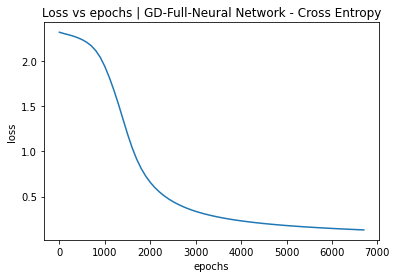

In [91]:
plt.title("Loss vs epochs | GD-Full-Neural Network - Cross Entropy")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)

In [92]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9700765483646486
Test accuracy: 0.95


### **#3.** Re-train the above model with `batch_size=64`. Also plot the graph of loss vs epochs.

In [93]:
#######
# !!!! YOUR CODE HERE !!!!
model = NN_Model()
criterion = torch.nn.CrossEntropyLoss()

model, losses = train_torch_model(model, batch_size=64, criterion = criterion, max_epochs= max_epochs, X_train = X_train_torch, y_train = y_train_one_torch, lr = lr, tolerance=tolerance )
#######

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3319032192230225


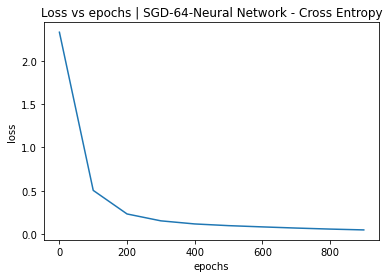

In [94]:
plt.title("Loss vs epochs | SGD-64-Neural Network - Cross Entropy")
plt.ylabel("loss")
plt.xlabel("epochs")

x, y = zip(*losses)
plt.plot(x,y)

In [95]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9965205288796103
Test accuracy: 0.9666666666666667




---



### **(e)**  In the above few problems, you performed several experiments with different batch size and loss functions. Write down an analysis of your observations from the results. (5 points)
Some points that you could cover are:
* Effect of using full vs. batch gradient descent.
* Effect of different loss strategy on performance.
* Effect of using linear vs. non-linear models.
* Training time per epoch in different cases.

Also, plot a line graph of accuracy vs. model for both train and test sets. Recall that you trained the following models in this question:

1.   Linear Model - Scratch + MSE Loss + Full Batch 
2.   Linear Model - Scratch + MSE Loss + Mini Batch 
3.   Linear Model - PyTorch + MSE Loss + Full Batch 
4.   Linear Model - PyTorch + MSE Loss + Mini Batch 
5.   Linear Model - PyTorch + CE Loss + Full Batch 
6.   Linear Model - PyTorch + CE Loss + Mini Batch 
7.   NN Model - PyTorch + CE Loss + Full Batch 
8.   NN Model - PyTorch + CE Loss + Mini Batch 


#### <font color="red">Your answer here:</font>



---



---

